In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc
from sklearn.svm import SVC

from adad.evaluate import (cumulative_accuracy, permutation_auc,
                           predictiveness_curves, roc_ad,
                           sensitivity_specificity)


In [3]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/applicabilityDomain


In [4]:
file_data = os.path.join(PATH_ROOT, "data", "maccs", "Ames_maccs.csv")
dataset = pd.read_csv(file_data)
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x159,x160,x161,x162,x163,x164,x165,x166,x167,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0


In [5]:
file_idx_train = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_test.csv")

cv_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
cv_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())

col = cv_train.columns[0]
idx_train = cv_train[col].dropna(axis=0).to_numpy().astype(int)
idx_test = cv_test[col].dropna(axis=0).to_numpy().astype(int)

In [6]:
y = dataset['y'].to_numpy().astype(int)
X = dataset.drop(['y'], axis=1).to_numpy().astype(np.float32)
X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

In [7]:
clf = SVC(C=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_train = clf.score(X_train, y_train)
acc_test = np.mean(y_pred == y_test)
print('Accuracy Train: {:.2f}% Test: {:.2f}%'.format(acc_train * 100, acc_test * 100))

Accuracy Train: 93.97% Test: 81.57%


In [8]:
from adad.bounding_box import PCABoundingBox

ad = PCABoundingBox(clf, n_components=10, min_ci=0.8, n_stages=50, filter_train=True)
ad.fit(X_train, y_train)


Apply filter Before: 5204 After: 4890


In [9]:
dm = ad.measure(X_test)

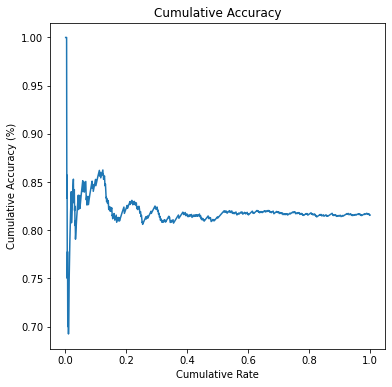

In [10]:
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dm)

plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

In [11]:
perm_auc, _ = permutation_auc(y_test, y_pred, dm)
print(perm_auc)

0.5245968201233983


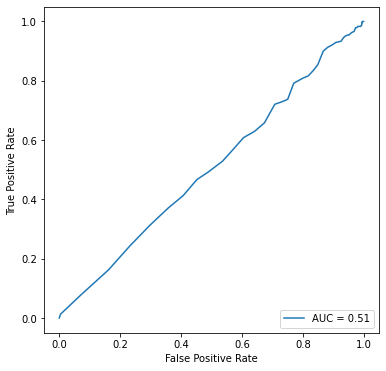

In [12]:
fpr, tpr = roc_ad(y_test, y_pred, dm)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot(ax=ax)
plt.show()

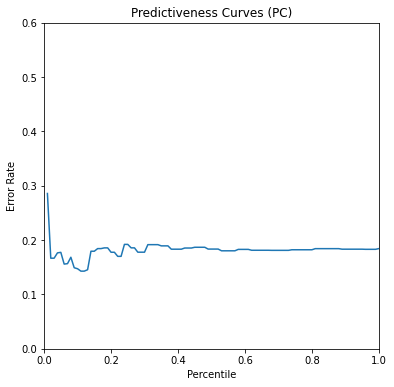

In [13]:
percentile, error_rate = predictiveness_curves(y_test, y_pred, dm)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, error_rate)
ax.set_xlabel("Percentile")
ax.set_xlim(0., 1.)
ax.set_ylabel("Error Rate")
ax.set_ylim(0, 0.6)
ax.set_title("Predictiveness Curves (PC)")
plt.show()